In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from nltk.corpus import gutenberg, stopwords
from collections import Counter
from textblob import TextBlob
from IPython.display import display

In [2]:
print(gutenberg.fileids())

['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']


In [3]:
# Utility function for standard text cleaning.
def text_cleaner(text):
    text = str(text)
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = re.sub('\n'," ",text)
    text = re.sub('\r'," ",text)
    return text

def mlist(story):
    return [text_cleaner(i) for i in TextBlob(re.sub(r'Chapter \d+', '', story)).sentences]

def mtokens(story):
    return [list(i.words.lower()) for i in TextBlob(re.sub(r'Chapter \d+', '', story)).sentences]

In [4]:
# Load and clean the data.
chestertonbrown = mlist(gutenberg.raw('chesterton-brown.txt'))
edgeworth = mlist(gutenberg.raw('edgeworth-parents.txt'))
alice = mlist(gutenberg.raw('carroll-alice.txt'))

In [5]:
sentences = chestertonbrown + alice + edgeworth

In [6]:
def nl(name,data):
    return [name for i in range(len(data))]
name = nl('chesterton',chestertonbrown)+nl('edgeworth',edgeworth)+nl('carroll',alice)

In [7]:
stories = pd.DataFrame([sentences,name]).T.sample(frac=1,random_state=42)
stories.columns = ['sentence','author']

In [8]:
vectorizer = TfidfVectorizer(max_df=0.3,
                             min_df=2,
                             stop_words='english', 
                             lowercase=True, #lower case
                             use_idf=True,#inverse document frequencies in our weighting
                             norm=u'l2', #orrection factor longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies
                            )

X_train, y_train = stories.sentence,stories.author

#Applying the vectorizer
stories_paras_tfidf=vectorizer.fit_transform(X_train)
print("Number of features: %d" % stories_paras_tfidf.get_shape()[1])

#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = stories_paras_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]

#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]

Number of features: 7289


In [11]:
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', stories.iloc[5])
print('Tf_idf vector:', tfidf_bypara[5])

Original sentence: sentence    A few days ago I had fine things in  readiness...
author                                                carroll
Name: 14641, dtype: object
Tf_idf vector: {'things': 0.21923749733883507, 'days': 0.2732085747623572, 'ago': 0.27665408626225235, 'fine': 0.25092178229335477, 'readiness': 0.38622264247619537, 'countess': 0.3581776912464113, 'flora': 0.29732225040867244, 'birthday': 0.2892030514487393, 'celebrated': 0.3417724464424339, 'count': 0.27944555937261145, 'villa': 0.3056082962527167}


In [12]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

In [13]:
svd= TruncatedSVD(400)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(stories_paras_tfidf)
variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()

In [80]:
#Looking at what sorts of paragraphs our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_train_lsa,index=X_train.index)
paras_by_component['author'] = stories.author
paras_by_component['sentence'] = stories.sentence

In [83]:
pd.options.display.width = 100
pd.options.display.max_colwidth = 100

In [84]:
stories.sentence[0:2]

10289                                                              He never could see it.
3101     "Oh, there are sermons in a cruet-stand, too," said Father Brown, quite gravely.
Name: sentence, dtype: object

In [85]:
list(X_train)[0:2]

['He never could see it.',
 '"Oh, there are sermons in a cruet-stand, too," said Father Brown, quite gravely.']

In [86]:
for i in range(5):
    component = i
    print('Component {}:'.format(component))
    df = pd.DataFrame(data = paras_by_component[[component,'author','sentence']]).sort_values(by=component,ascending=False)[5:50:5]
    df = df.reset_index();del df['index'];df.columns=['Similarity','Author','Sentence']
    display(df)
    print('')

Component 0:


,Similarity,Author,Sentence
0,0.848149,chesterton,he said.
1,0.848149,edgeworth,said the others.
2,0.848149,edgeworth,"""Very well,"" said she."
3,0.848149,edgeworth,"said she; ""then I can't have it."
4,0.848149,edgeworth,"Another said, ""No."""
5,0.843880,edgeworth,said one of the jurymen.
6,0.836491,edgeworth,said the Lory.
7,0.809983,edgeworth,"""I said I could bear to see all this, and I can,"" said he; ""now it is all over."""
8,0.782162,edgeworth,"She always shows us where the nicest flowers are to be found in the lanes and meadows,"" said they."



Component 1:


,Similarity,Author,Sentence
0,0.547007,edgeworth,"""I don't know, except it was idleness."""
1,0.513016,chesterton,I don't know this gentleman but but I think I know him.
2,0.500230,chesterton,"""How do you know I know?"""
3,0.500230,chesterton,"""But how do you know?"""
4,0.500230,edgeworth,"Who is 'YOU KNOW WHO?'"""
5,0.495058,edgeworth,"You know, I have settled with you."
6,0.490100,edgeworth,"""I don't know well what tires me; grandmother says I'm ill, and I must take something I don't k..."
7,0.479297,edgeworth,"You know the song, perhaps?'"
8,0.464454,edgeworth,"""Oh, why, famous means now, don't you know what famous means?"



Component 2:


,Similarity,Author,Sentence
0,0.824404,edgeworth,Just.
1,0.824404,edgeworth,Just.
2,0.824404,edgeworth,Just.
3,0.824404,edgeworth,Just.
4,0.824404,edgeworth,Just.
5,0.824404,edgeworth,Just.
6,0.824404,edgeworth,Just.
7,0.824404,edgeworth,Just.
8,0.824404,edgeworth,Just.



Component 3:


,Similarity,Author,Sentence
0,0.900023,edgeworth,"""Oh, no."
1,0.900023,edgeworth,"""Oh, no."""
2,0.900023,edgeworth,Oh!
3,0.900023,edgeworth,"Oh, not he."
4,0.900023,edgeworth,"""Oh!"""
5,0.898941,edgeworth,"""Oh, fie!"
6,0.896336,carroll,"""Oh, that I dared to disobey!"""
7,0.883983,edgeworth,Oh la!
8,0.853240,edgeworth,"""Oh, no, you must not touch it; for if you should spoil it, what would become of me?"""



Component 4:


,Similarity,Author,Sentence
0,0.432195,edgeworth,"""'YOU KNOW WHO!'"
1,0.432195,carroll,"I WILL know."""
2,0.432195,chesterton,"""How do you know I know?"""
3,0.424986,edgeworth,"Many know how to give, but few know how to accept a gift properly."
4,0.417177,edgeworth,"""It can't be helped how do you know that?"""
5,0.399791,edgeworth,"You know the song, perhaps?'"
6,0.391528,edgeworth,"""And don't you know me?"""
7,0.386900,edgeworth,"""I don't know, except it was idleness."""
8,0.372327,edgeworth,Just.


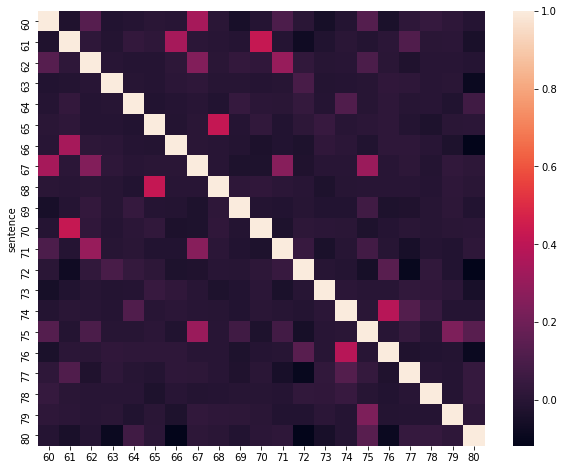

Key:
60-chesterton: Then, as if changing the subject, he said abruptly:  "He has a daughter and a son."
61-edgeworth: When she came to the story of her lamb, her  voice faltered, and everybody present was touched.
62-edgeworth: I daresay you are quite correct; you must know best,"  said the attorney, trembling for the agency.
63-edgeworth: This  promise was enough even for Archer.
64-edgeworth: Alice had no idea what to do, and in despair she put her hand in her pocket, and pulled out a box of
65-edgeworth: The consequences of this intimacy we shall presently see.
66-edgeworth: Her voice was not so sprightly, but it was sweeter  than usual.
67-chesterton: "I said by his own orders."
68-edgeworth: I am sure I shall be as much  obliged if you do come.
69-edgeworth: 'That's very curious!'
70-edgeworth: Go, go,  for the present.
71-edgeworth: I'm quite tired, and I will do no  more," said Frederick, stretching himself at full length upon a s
72-edgeworth: Go!
73-chesterton: "He has been wa

In [148]:
r = range(60,81)
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[r[0]:r[-1]+1,r[0]:r[-1]+1]
#Making a plot
plt.figure(figsize=(10,8))
ax = sns.heatmap(sim_matrix,yticklabels=r)
plt.show()

#Generating a key for the plot.
print('Key:')
for i in r:
    j = i-r[0]
    print("{}-{}: {}".format(i,stories.author.iloc[i],sim_matrix.index[j][0:100]))

In [154]:
%%time
from sklearn.mixture import GaussianMixture

gm_range = range(2,5,1)
gm_aic = []
gm_predict = []
gm_score = []

gm_x = X_train_lsa
gm_y = y_train
for i in gm_range:
    # Declare and fit the model.
    gm = GaussianMixture(n_components=i,n_init=10,init_params='random')
    gm.fit(gm_x)
    # gm_predict.append(km.predict_fit(X_test_tfidf))
    gm_aic.append(gm.aic(gm_x))
    gm_predict.append(gm.predict(gm_x))
    gm_score.append(gm.score(gm_x,gm_y))
    
    
    #Predicted clusters.
    print('{} completed'.format(i),end=' | ')

2 completed | 3 completed | 4 completed | CPU times: user 53min 39s, sys: 4min 40s, total: 58min 20s
Wall time: 30min 29s


In [155]:
from pprint import pprint

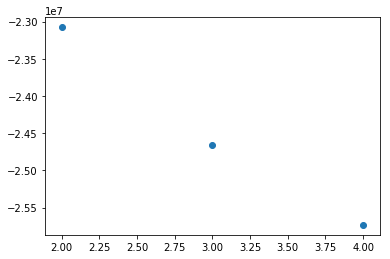

In [159]:
plt.scatter(x=[2,3,4],y=gm_aic)
plt.savefig('aic.jpg')

### _K Means Clustering_

In [15]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans

In [16]:
%%time
km_range = range(2,8)
km_predict = []
for i in km_range:
    # Declare and fit the model.
    km = KMeans(n_clusters=i, random_state=42)
    km.fit(X_train_tfidf)
    km_predict.append(km.predict(X_test_tfidf))

    #Predicted clusters.
    print('{} completed'.format(i),end=' | ')

2 completed | 3 completed | 4 completed | 5 completed | 6 completed | 7 completed | CPU times: user 1min 14s, sys: 1.16 s, total: 1min 16s
Wall time: 41.4 s


In [17]:
%%time
mb_range = range(2,8)
mb_predict = []
for i in mb_range:
    # Declare and fit the model.
    mb = MiniBatchKMeans(
                        init='random',
                        n_clusters=i,
                        batch_size=10)
    mb.fit(X_train_tfidf)
    mb_predict.append(mb.predict(X_test_tfidf))

    #Predicted clusters.
    print('{} completed'.format(i),end=' | ')

2 completed | 3 completed | 4 completed | 5 completed | 6 completed | 7 completed | CPU times: user 4.43 s, sys: 69.1 ms, total: 4.5 s
Wall time: 2.37 s


# 5. Evaluate (w/ different criterion)

In [165]:
from sklearn.metrics import v_measure_score

## _V-Measurement Criterion_

In [166]:
table = pd.crosstab(y_train, gm_predict[1],margins = True)
table.index = list(y_train.unique()) + ['total'];table

col_0,0,1,2,All
edgeworth,666,592,367,1625
chesterton,1278,1743,691,3712
carroll,4213,2944,2939,10096
total,6157,5279,3997,15433
